1. Imports y configuración general


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import time
import warnings
warnings.filterwarnings('ignore')


2. Carga de datos y preprocesamiento

In [3]:
# Carga de datos
df = pd.read_csv('data/processed/diabetes_processed.csv')
X = df.drop('Complicacion', axis=1)
y = df['Complicacion'].astype(int)  # 0/1 binaria

# Label encoding si hay variables categóricas
from sklearn.preprocessing import LabelEncoder
X_encoded = X.copy()
for col in X.columns:
    if X[col].dtype == 'object':
        X_encoded[col] = LabelEncoder().fit_transform(X[col])

# Split inicial para holdout final
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)


3. Definición de modelos a comparar

In [4]:
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(random_state=42, max_iter=300),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}


4. Validación cruzada con StratifiedKFold (AUC, accuracy, tiempo)

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_df = []

for name, model in modelos.items():
    print(f"Evaluando {name}...")
    start = time.time()
    auc_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kfold)
    acc_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
    end = time.time()
    scores_df.append({
        'Modelo': name,
        'AUC_mean': np.mean(auc_scores),
        'AUC_std': np.std(auc_scores),
        'Accuracy_mean': np.mean(acc_scores),
        'Accuracy_std': np.std(acc_scores),
        'Tiempo(s)': round(end - start, 2)
    })
scores_df = pd.DataFrame(scores_df)
display(scores_df.sort_values('AUC_mean', ascending=False))


Evaluando Logistic Regression...
Evaluando Decision Tree...
Evaluando Random Forest...
Evaluando KNN...
Evaluando SVM...
Evaluando Naive Bayes...
Evaluando MLP...
Evaluando XGBoost...
Evaluando LightGBM...
[LightGBM] [Info] Number of positive: 11863, number of negative: 43775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 55638, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.213218 -> initscore=-1.305639
[LightGBM] [Info] Start training from score -1.305639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

,Modelo,AUC_mean,AUC_std,Accuracy_mean,Accuracy_std,Tiempo(s)
0,Logistic Regression,1.000000,0.000000,1.000000,0.000000,5.42
1,Decision Tree,1.000000,0.000000,1.000000,0.000000,0.20
2,Random Forest,1.000000,0.000000,1.000000,0.000000,7.21
10,Gradient Boosting,1.000000,0.000000,1.000000,0.000000,10.30
9,CatBoost,1.000000,0.000000,1.000000,0.000000,55.19
8,LightGBM,1.000000,0.000000,1.000000,0.000000,2.31
7,XGBoost,1.000000,0.000000,1.000000,0.000000,0.76
5,Naive Bayes,0.999817,0.000076,0.998433,0.000190,0.32
3,KNN,0.985922,0.000856,0.971602,0.000995,7.20
6,MLP,0.712835,0.107674,0.672072,0.229422,78.64


5. Optimización de hiperparámetros con GridSearchCV (ejemplo con Random Forest y XGBoost)

In [6]:
param_rf = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_rf, scoring='roc_auc', cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Random Forest mejor AUC:", grid_rf.best_score_, "con params:", grid_rf.best_params_)

param_xgb = {'max_depth': [3, 5], 'n_estimators': [100, 200]}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(xgb, param_xgb, scoring='roc_auc', cv=3, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print("XGBoost mejor AUC:", grid_xgb.best_score_, "con params:", grid_xgb.best_params_)


Random Forest mejor AUC: 1.0 con params: {'max_depth': 5, 'n_estimators': 100}
XGBoost mejor AUC: 1.0 con params: {'max_depth': 3, 'n_estimators': 100}


6. Feature Importance Global (modelos tipo árbol y ensemble)

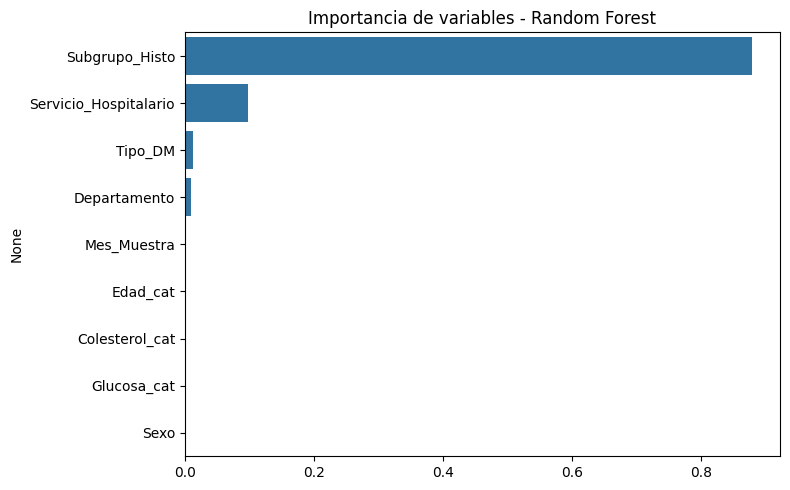

In [7]:
# Random Forest feature importance (ejemplo)
feat_imp_rf = pd.Series(grid_rf.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp_rf.values, y=feat_imp_rf.index)
plt.title('Importancia de variables - Random Forest')
plt.tight_layout()
plt.show()


7. Boxplot de las métricas por fold/modelo

[LightGBM] [Info] Number of positive: 11863, number of negative: 43775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 55638, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.213218 -> initscore=-1.305639
[LightGBM] [Info] Start training from score -1.305639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

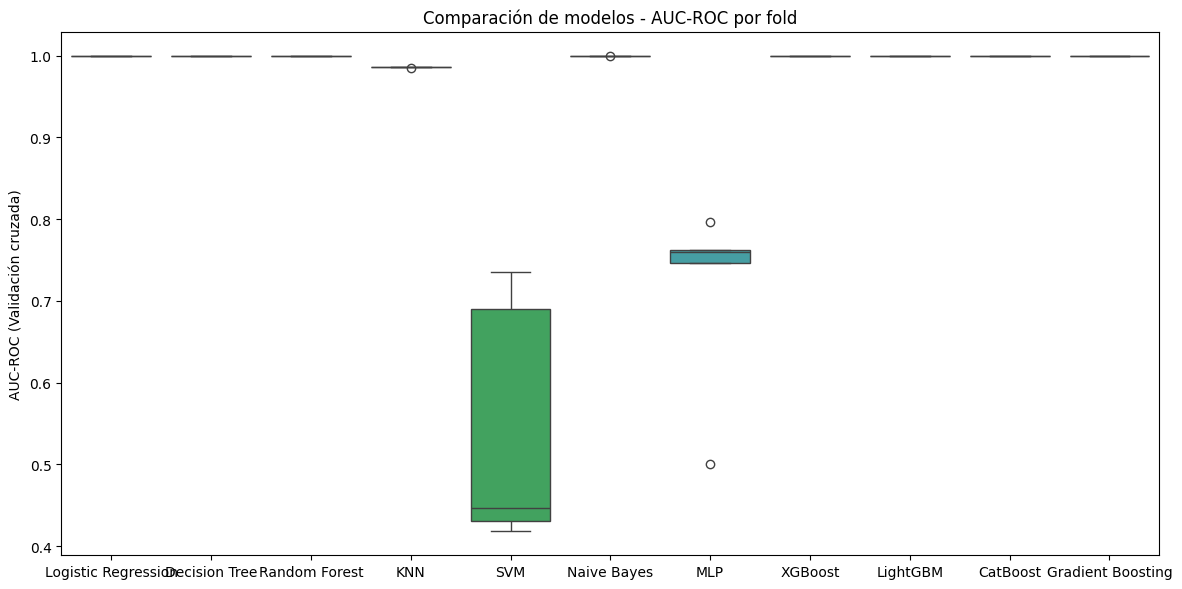

In [8]:
# Guardar los scores individuales por fold
results = {}
for name, model in modelos.items():
    auc_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kfold)
    results[name] = auc_scores

# DataFrame para boxplot
results_df = pd.DataFrame(results)
plt.figure(figsize=(12,6))
sns.boxplot(data=results_df)
plt.ylabel('AUC-ROC (Validación cruzada)')
plt.title('Comparación de modelos - AUC-ROC por fold')
plt.tight_layout()
plt.show()


8. Evaluación final en conjunto de prueba (holdout)

In [9]:
# Entrena mejores modelos y evalúa en test final
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train, y_train)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]
print("AUC-ROC final (Random Forest):", roc_auc_score(y_test, y_proba_rf))

# Haz lo mismo para XGBoost o los que optimizaste


AUC-ROC final (Random Forest): 1.0


9. Curvas ROC finales de los modelos top

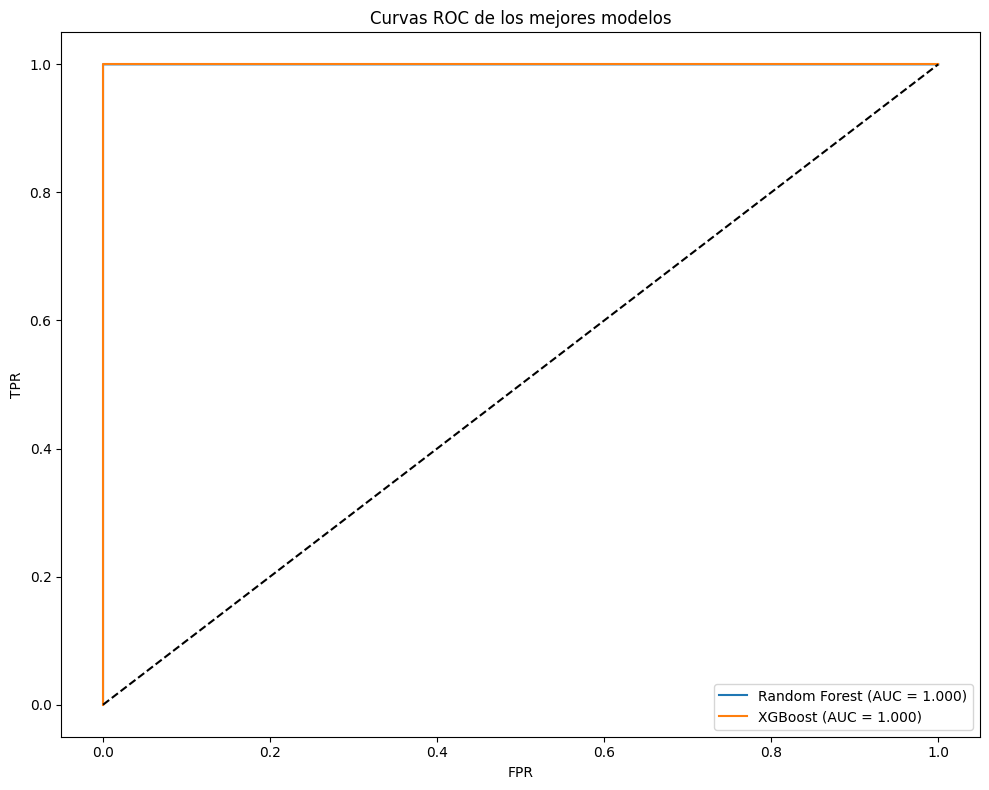

In [10]:
plt.figure(figsize=(10,8))
for name, model in [('Random Forest', best_rf), ('XGBoost', grid_xgb.best_estimator_)]:
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC de los mejores modelos')
plt.legend()
plt.tight_layout()
plt.show()


Boxplot avanzado de AUC-ROC + Medias y Destacados

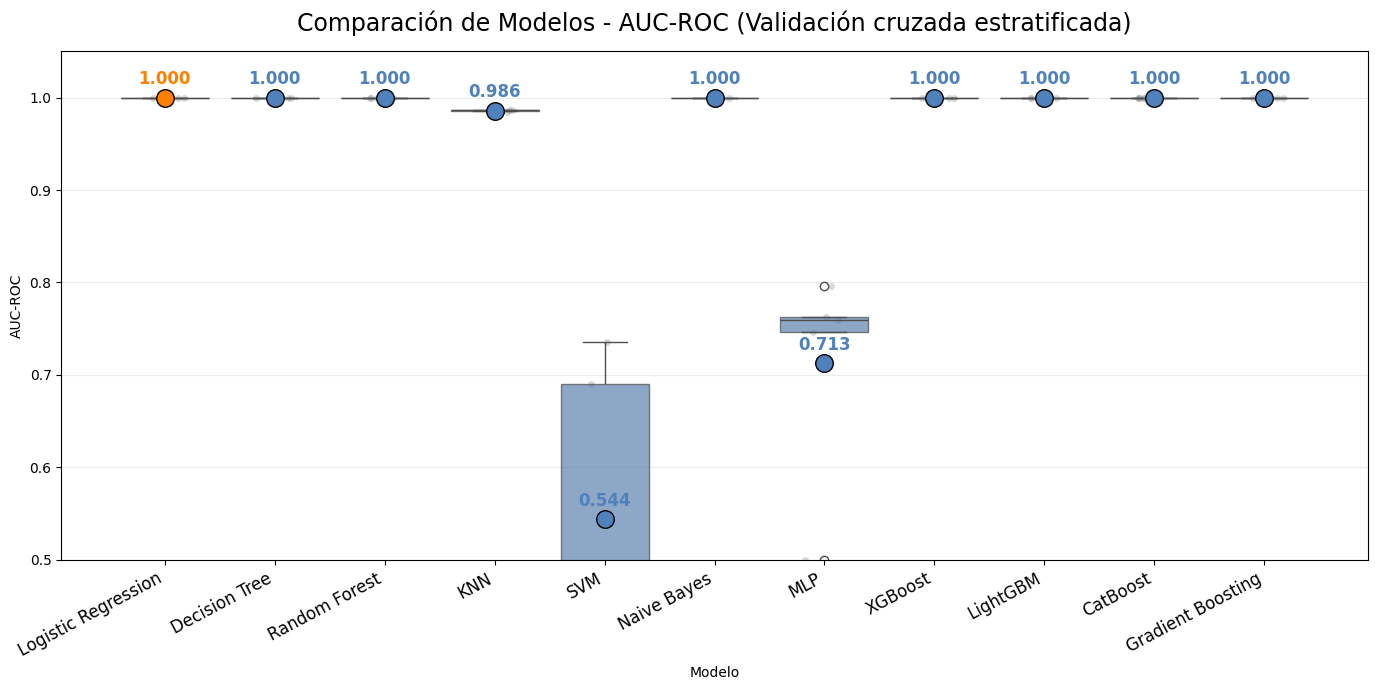

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supón que results_df es un DataFrame de shape (n_folds, n_modelos) con scores AUC-ROC de cada fold y modelo
# Ejemplo rápido de generación (si ya tienes results_df, ignora esto)
# results_df = pd.DataFrame({nombre: cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kfold) for nombre, model in modelos.items()})

# Cálculo de medias y colores
mean_auc = results_df.mean()
best_model = mean_auc.idxmax()
colors = ['#4F81BD' if col != best_model else '#FF8000' for col in results_df.columns]

plt.figure(figsize=(14,7))
box = sns.boxplot(data=results_df, palette=colors, showmeans=False, boxprops=dict(alpha=0.7))
sns.stripplot(data=results_df, color='gray', alpha=0.3, jitter=0.18, zorder=0)

# Marcar la media de cada modelo
for i, modelo in enumerate(results_df.columns):
    plt.scatter(i, mean_auc[modelo], s=160, color=colors[i], edgecolor='black', zorder=10)
    plt.text(i, mean_auc[modelo]+0.01, f"{mean_auc[modelo]:.3f}", ha='center', va='bottom', fontweight='bold', fontsize=12, color=colors[i])

plt.title('Comparación de Modelos - AUC-ROC (Validación cruzada estratificada)', fontsize=17, pad=15)
plt.ylabel('AUC-ROC')
plt.xlabel('Modelo')
plt.xticks(rotation=28, ha='right', fontsize=12)
plt.grid(axis='y', alpha=0.25)
plt.ylim(0.5, 1.05)
plt.tight_layout()
plt.savefig('output/resultados/boxplot_aucroc_estratificada_modelos.png', dpi=300, bbox_inches='tight')
plt.show()
